In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sys import version
print(version)

3.6.2 |Anaconda custom (64-bit)| (default, Sep 21 2017, 18:29:43) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [3]:
train = pd.read_csv("../winter_data/aggregates/15min/train.tsv.gz", sep="\t")
xval = pd.read_csv("../winter_data/aggregates/15min/xval.tsv.gz", sep="\t")
print(list(train.columns))

['opd_date', 'trip_start_hr_15', 'rte', 'dir', 'day_of_week', 'is_ns', 'is_inbound', 'is_rapid', 'is_weekend', 'orca_total', 'orca_apc_ratio', 'frac_disabled', 'frac_youth', 'frac_senior', 'frac_li', 'frac_uw', 'ons', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyWindSpeed']


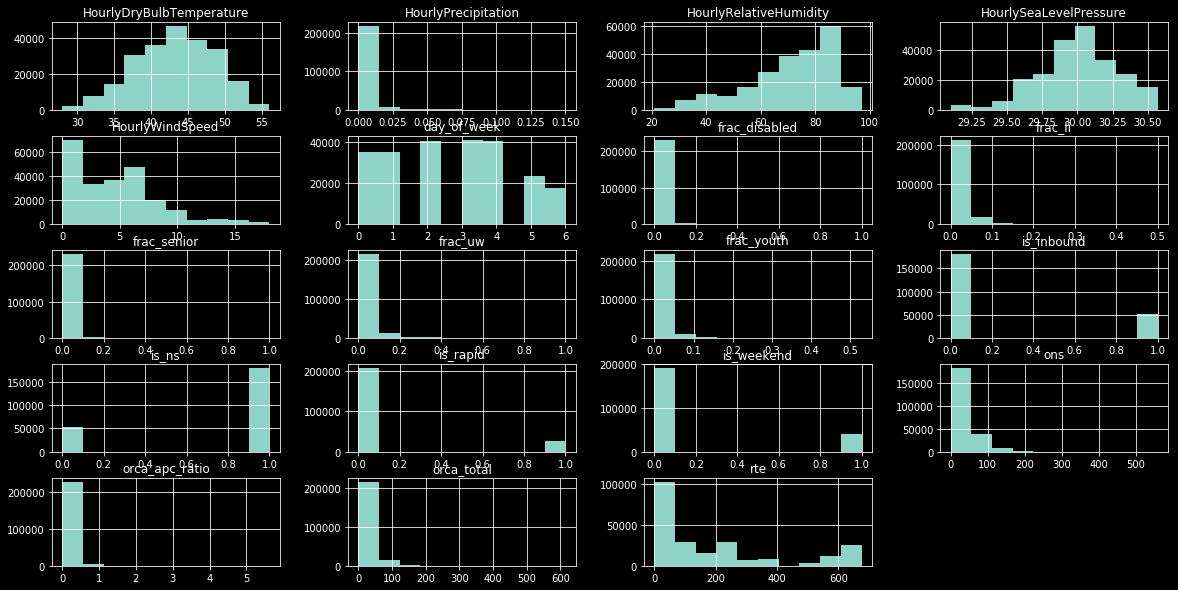

In [6]:
plt.style.use('dark_background')
train.hist(figsize=(20, 10))
plt.show()

In [10]:
X_NUM_COLS = ['is_ns', 'is_inbound', 'is_rapid', 'is_weekend', 'trip_start_hr_15', 'orca_total', 'frac_disabled', 'frac_youth', 'frac_senior', 'frac_li', 'frac_uw', 'HourlyDryBulbTemperature', 'HourlyPrecipitation', 'HourlyRelativeHumidity', 'HourlySeaLevelPressure', 'HourlyWindSpeed']
X_CAT_COLS = ['rte', 'dir', 'day_of_week']

from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

label_encoders = {col: LabelEncoder() for col in X_CAT_COLS}
one_hot_encoder = OneHotEncoder()
scaler = StandardScaler()

X_train = np.concatenate((
    scaler.fit_transform(train[X_NUM_COLS]),
    one_hot_encoder.fit_transform(
        np.stack([label_encoders[col].fit_transform(train[col]) for col in X_CAT_COLS]).T
    ).todense()
), axis=1)
X_xval = np.concatenate((
    scaler.transform(xval[X_NUM_COLS]),
    one_hot_encoder.transform(
        np.stack([label_encoders[col].transform(xval[col]) for col in X_CAT_COLS]).T
    ).todense()
), axis=1)

y_train = train['ons']
y_xval = xval['ons']
print(X_train.shape)
print(X_xval.shape)
print(y_train.shape)
print(y_xval.shape)

(231564, 196)
(29289, 196)
(231564,)
(29289,)


In [11]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=1)
reg.fit(X_train, y_train)

y_preds = reg.predict(X_train)
y_xval_preds = reg.predict(X_xval)

def mape(pred, true):
    err = np.abs(pred-true)
    return np.where(true!=0, err/true, 0).mean()

print(f"training mape: {mape(y_preds, y_train):%}")
print(f"training mae: {np.abs(y_preds-y_train).mean()}")
print(f"xval mape: {mape(y_xval_preds, y_xval):%}")
print(f"xval mae: {np.abs(y_xval_preds-y_xval).mean()}")

training mape: 36.368301%
training mae: 9.114150695181092
xval mape: 37.352633%
xval mae: 9.104936967372192


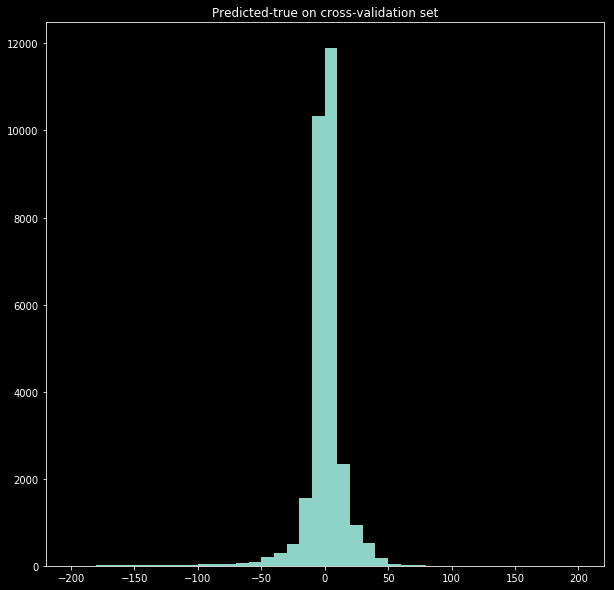

In [12]:
plt.figure(figsize=(10, 10))
plt.hist(y_xval_preds-y_xval, bins=40, range=(-200, 200))
plt.title("Predicted-true on cross-validation set")
plt.show()

In [15]:
from os import makedirs
makedirs("../predictions", exist_ok=True)
with open('../predictions/linear-xval.txt', 'wt') as fh:
    for pred in y_xval_preds:
        fh.write(str(pred) + '\n')